In [1]:
import spacy
from spacy.matcher import Matcher
import re
from datetime import datetime
from spacy.matcher import PhraseMatcher
from skillNer.general_params import SKILL_DB
from skillNer.skill_extractor_class import SkillExtractor
from spacy import displacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from dateparser.search import search_dates
import pandas as pd
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from tabulate import tabulate
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import fitz  # PyMuPDF
import warnings

# Ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Initialize stop words
stop_words = STOP_WORDS

# Load spaCy model
nlp = spacy.load('en_core_web_lg')
matcher = Matcher(nlp.vocab)


In [2]:
# Path to resume file
resume_path = r"C:\Users\khmir\Desktop\cvs\khmiri_iheb_tun_fr.pdf"

# Extracting text from PDF using PyMuPDF
with fitz.open(resume_path) as doc:
    cc = ""
    for page in doc:
        cc += page.get_text()

# Process the text with spaCy
doc = nlp(cc)

# Print the first 1000 characters of the processed text (you can adjust the size)
print(doc[:1000])


KHMIRI IHEB
Résumé du Profil
Diplômé en ingénierie
informatique spécialisé en
Business Intelligence, passionné
par l’analyse de données. Je
recherche une première
expérience professionnelle pour
approfondir mes compétences et
contribuer à des projets
innovants.
Contact details
@ khmiri.iheb@esprit.tn
H +216 29 118 233
° khmiri iheb
 ihebkh
 khmiri iheb
Compétences
• Développement Web:.NET
Core, Spring Boot, Angular,
Next.js, FastAPI, Django
• Intégration des données
Airflow, SSIS, SSAS, Talend,
Microsoft Power BI
• DEVOPS: Docker , JUnit ,
Mockito , Sonarqube, Nexus ,
JenKins , Grafana ,
Prometheus
• Administration de bases de
données : SSMS, Oracle,
PostgreSQL, MongoDB, SQL
Workbench , MySQL
• ERP / CRM: SAP Abap , SAP
Fiori , SAP S/4HANA, SAP BW
,Microsoft power apps ,
Microsoft Dynamics 365
Compétences
• Arabe: Native
• Français: B2
• Anglais: B2
EXPERIENCE PROFESSIONNELLE
DigitalCook , France
Stage en Business Intelligence
Février 2025 – Août 2025
Swiss Premium Negoce SA ,Swisse


In [3]:
# Define various date patterns
date_patterns = [
    [{"TEXT": {"regex": r"\b\d{1,2}[/-]\d{1,2}[/-]\d{4}\b"}}],  # MM/DD/YYYY, MM-DD-YYYY, or MM.DD.YYYY
    [{"TEXT": {"regex": r"(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)"}, "OP": "?"}, 
      {"TEXT": ",", "OP": "?"}, 
      {"IS_DIGIT": True, "OP": "?"}, 
      {"TEXT": {"regex": r"\d{4}"}}],  # Month Day, Year format (e.g., Jan 2020)
    [{"TEXT": {"regex": r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{4}"}}],  # Month Year (e.g., Jan 2020)
    [{"TEXT": {"regex": r"\b\d{4}\b"}}],  # Year only (e.g., 2020)
    [{"TEXT": {"regex": r"\b\d{1,2}[/-]\d{4}\b"}}],  # Month-Year format (e.g., 12/2020 or 12-2020)
    [{"TEXT": {"regex": r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2}"}}]  # Month-Day format (e.g., Jan 5)
]

# Add the date patterns to the matcher
for pattern in date_patterns:
    matcher.add("DATE_PATTERN", [pattern], on_match=None)

# Apply the matcher to the document
matches = matcher(doc)

# Extract matched date patterns and print
matched_dates = []
for match_id, start, end in matches:
    span = doc[start:end]  # Get the matched span of text
    matched_dates.append(span.text)

# Display the matched dates
print("Matched Dates:", matched_dates)


Matched Dates: ['2025', '2025', '2024', '2024', 'Janvier 2024', '2024', '2024', '2020', '2019', '2020', 'October 2024', '2024', '2024', '2024']


In [7]:
# Function to calculate total years of experience in months
def calculate_total_experience_in_months(resume_path):
    # Extracting text from PDF again
    with fitz.open(resume_path) as doc:
        cc = ""
        for page in doc:
            cc += page.get_text()

    lines = cc.splitlines()
    printed_lines = set()
    total_months = 0

    # Loop through each line and try to calculate the experience
    for line in lines:
        line = line.lower()
        line = re.sub(r"\b(months?|years?|mos|yr|yrs|mois|an|ans)\b", "", line, flags=re.IGNORECASE)
        line = line.replace(".", " ") 
        line = line.replace("present", datetime.now().strftime("%b %d, %Y"))
        line = line.replace("today", datetime.now().strftime("%b %d, %Y"))
        line = line.replace("now", datetime.now().strftime("%b %d, %Y"))
        line = line.replace("aujourd'hui", datetime.now().strftime("%b %d, %Y"))

        # Process each line with spaCy
        doc = nlp(line)
        parsed_date = search_dates(line, languages=["fr", "en"])

        if parsed_date is not None:
            parsed_date = [date[1] for date in parsed_date]

        for ent in doc.ents:
            if ent.label_ == "DATE" and line not in printed_lines:
                if parsed_date is not None and len(parsed_date) >= 2:
                    parsed_date.sort()
                    date1, date2 = parsed_date[:2]
                    diff_months = (date2.year - date1.year) * 12 + (date2.month - date1.month)
                    total_months += diff_months
                    printed_lines.add(line)

    # Convert total months to years and months
    years = total_months // 12
    months = total_months % 12
    return years, months

# Get total experience in years and months
years, months = calculate_total_experience_in_months(resume_path)
print(f"Total experience: {years} years and {months} months")


C:\Users\khmir\AppData\Local\Temp\ipykernel_15624\266823793.py:25: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  parsed_date = search_dates(line, languages=["fr", "en"])


Total experience: 1 years and 11 months


In [8]:
def display_token_info(doc):
    token_info = defaultdict(lambda: {"count": 0, "is_alpha": None, "is_digit": None, "is_punct": None, "is_stop": None,"is_blank_space": None ,"pos": None, "dep":None})

    for token in doc:
        token_text = token.text
        token_info[token_text]["count"] += 1
        if token_info[token_text]["is_alpha"] is None:
            token_info[token_text]["is_alpha"] = token.is_alpha
        if token_info[token_text]["is_digit"] is None:
            token_info[token_text]["is_digit"] = token.is_digit
        if token_info[token_text]["is_punct"] is None:
            token_info[token_text]["is_punct"] = token.is_punct
        if token_info[token_text]["is_stop"] is None:
            token_info[token_text]["is_stop"] = token.is_stop
        token_info[token_text]["is_blank_space"] = token_text.isspace()
        if token_info[token_text]["pos"] is None:
            token_info[token_text]["pos"] = token.pos_
        if token_info[token_text]["dep"] is None:
            token_info[token_text]["dep"] = token.dep_      
    # Combine duplicate blank space tokens into a single entry
    blank_space_tokens = [token_text for token_text in token_info if token_info[token_text]["is_blank_space"]]
    if blank_space_tokens:
        total_count = sum(token_info[token_text]["count"] for token_text in blank_space_tokens)
        first_token = blank_space_tokens[0]
        token_info[first_token]["count"] = total_count
        for token_text in blank_space_tokens[1:]:
            del token_info[token_text]

    stopwords = set([token.text for token in doc if token.is_stop])
    print(f"Stopwords: {stopwords}")
   
    table_headers = ["Token", "Occurrence", "Is Alpha", "Is Digit", "Is Punct", "Is Stop",  "Is Blank Space","POS","Dep"]
    table_data = [[token_text, info["count"], info["is_alpha"], info["is_digit"], info["is_punct"], info["is_stop"], info["is_blank_space"],info["pos"],info["dep"]] for token_text, info in token_info.items()]
    # tri descroissant par 2eme colonne occurence
    table_data.sort(key=lambda x: x[1], reverse=True)

    print(tabulate(table_data, headers=table_headers))

In [9]:
def before_data_cleaning(doc):
    length = len(doc)
    num_stopwords = len([token for token in doc if token.is_stop])
    num_blanks = sum(1 for token in doc if token.is_space)
    num_punctuations = len([token for token in doc if token.is_punct])
    num_digits = len([token for token in doc if token.is_digit])

    # Count number of email addresses
    emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', doc.text)
    num_emails = len(emails)
 

    print("Before Data Cleaning:")
    print(f"Length of document: {length}")
    print(f"Number of stopwords: {num_stopwords}")
    print(f"Number of blank spaces: {num_blanks}")
    print(f"Number of punctuations: {num_punctuations}")
    print(f"Number of digits: {num_digits}")
    print(f"Number of email addresses: {num_emails}")
    display_token_info(doc)

before_data_cleaning(doc)

Before Data Cleaning:
Length of document: 488
Number of stopwords: 4
Number of blank spaces: 78
Number of punctuations: 100
Number of digits: 16
Number of email addresses: 1
Stopwords: {'of', 'for'}
Token                    Occurrence  Is Alpha    Is Digit    Is Punct    Is Stop    Is Blank Space    POS    Dep
---------------------  ------------  ----------  ----------  ----------  ---------  ----------------  -----  --------
                                 78  False       False       False       False      True              SPACE  dep
,                                46  False       False       True        False      False             PUNCT  punct
•                                20  False       False       True        False      False             VERB   punct
de                               13  True        False       False       False      False             PROPN  compound
:                                11  False       False       True        False      False             PUNCT  

In [10]:
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher) 
def extract_skills(skill_extractor, cc):
    annotations = skill_extractor.annotate(cc)
    unique_values = set() 

    for item in annotations['results']['full_matches']:
        unique_values.add(item['doc_node_value'].lower())

    for item in annotations['results']['ngram_scored']:
        unique_values.add(item['doc_node_value'].lower())
    print(list(unique_values))
    return list(unique_values)



loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


After Data Cleaning:
Length of document: 226
Number of stopwords: 0
Number of blank spaces: 0
Number of punctuations: 0
Number of digits: 0
Number of email addresses: 0
Stopwords: set()
Token              Occurrence  Is Alpha    Is Digit    Is Punct    Is Stop    Is Blank Space    POS    Dep
---------------  ------------  ----------  ----------  ----------  ---------  ----------------  -----  --------
de                         13  True        False       False       False      False             X      nmod
et                         10  True        False       False       False      False             PROPN  compound
des                        10  True        False       False       False      False             PROPN  compound
en                          7  True        False       False       False      False             X      nmod
du                          5  True        False       False       False      False             PROPN  nmod
business                    4  True        Fals

c:\Users\khmir\AppData\Local\Programs\Python\Python313\Lib\site-packages\skillNer\utils.py:99: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  vec_similarity = token1.similarity(token2)


['etl', 'microsoft dynamics', 'junit', 'sap abap', 'airflow', 'jenkins', 'power bi', 'eda', 'tunis', 'tableau', 'sap sap', 'sap fiori', 'python', 'app microsoft', 'en', 'spring boot', 'sonarqube', 'mes', 'web scraping', 'talend', 'audit', 'django', 'erp', 'prometheus', 'sql', 'microsoft power', 'docker', 'stage', 'ssis', 'arabe', 'angular', 'grafana', 'machine learning', 'anomaly detection', 'mockito', 'workbench mysql', 'scrum', 'business intelligence', 'predictive maintenance', 'microsoft microsoft', 'natural language', 'mysql', 'machine learn', 'api', 'crm', 'postgresql', 'mongodb']
['etl', 'microsoft dynamics', 'junit', 'sap abap', 'airflow', 'jenkins', 'power bi', 'eda', 'tunis', 'tableau', 'sap sap', 'sap fiori', 'python', 'app microsoft', 'en', 'spring boot', 'sonarqube', 'mes', 'web scraping', 'talend', 'audit', 'django', 'erp', 'prometheus', 'sql', 'microsoft power', 'docker', 'stage', 'ssis', 'arabe', 'angular', 'grafana', 'machine learning', 'anomaly detection', 'mockito', '

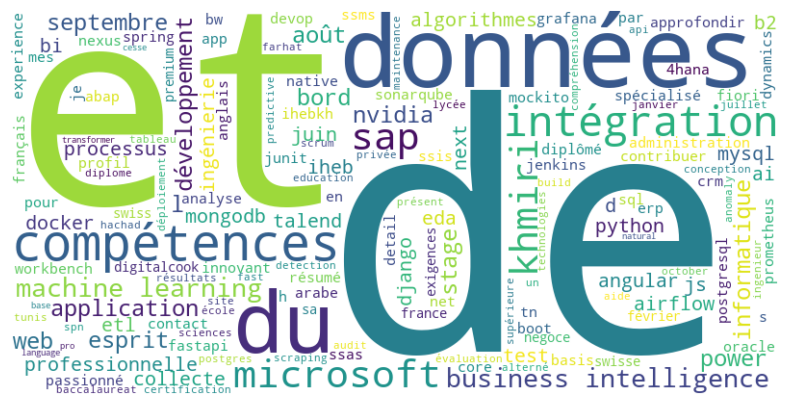

C:\Users\khmir\AppData\Local\Temp\ipykernel_15624\2750200711.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bbar.set_yticklabels(bbar.get_yticklabels(), fontsize=10)


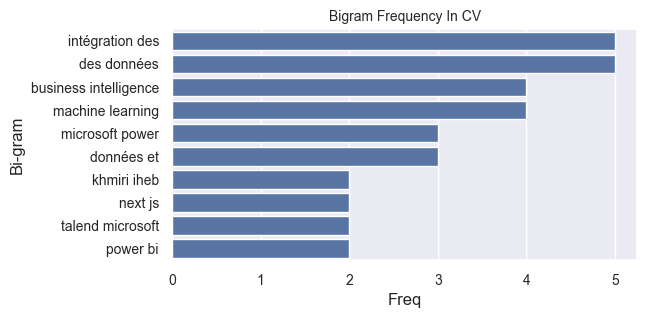

In [11]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
def after_data_cleaning(doc):
    # Remove stopwords, punctuations, and digits
    cleaned_doc = [token for token in doc if token.text.strip().encode('utf-8').isalpha() and not token.is_stop and not token.is_punct and not token.is_digit and not token.is_space]

    length = len(cleaned_doc)
    num_stopwords = len([token for token in cleaned_doc if token.is_stop])
    num_blanks = sum(1 for token in cleaned_doc if token.is_space)
    num_punctuations = len([token for token in cleaned_doc if token.is_punct])
    num_digits = len([token for token in cleaned_doc if token.is_digit])


    cleaned_text = ' '.join([token.lemma_.lower() for token in cleaned_doc])

 
    emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', cleaned_text)
    cleaned_text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', cleaned_text)

    num_emails = len(emails)
    
    print("After Data Cleaning:")
    print(f"Length of document: {length}")
    print(f"Number of stopwords: {num_stopwords}")
    print(f"Number of blank spaces: {num_blanks}")
    print(f"Number of punctuations: {num_punctuations}")
    print(f"Number of digits: {num_digits}")
    print(f"Number of email addresses: {num_emails}")
    cleaned_doc = nlp(cleaned_text)
    display_token_info(cleaned_doc)
    # Generate word cloud
    filtered_text = " ".join([token.lemma_.lower() for token in doc if token.pos_ in [ 'PROPN', 'ADJ','VERB','NOUN'] and token not in stop_words ])
    unique_values_list = extract_skills(skill_extractor, cleaned_text)
    print(unique_values_list)
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
# Tokenize the filtered text
    top2_words = get_top_n2_words([filtered_text], n=len(filtered_text.split()))

    # Create a DataFrame from the top bi-grams
    top2_df = pd.DataFrame(top2_words)
    top2_df.columns = ["Bi-gram", "Freq"]

    # Create the bar plot for bi-grams
    sns.set(rc={'figure.figsize':(6,3)})
    bbar = sns.barplot(y="Bi-gram", x="Freq", orient='h', data=top2_df[:10])
    plt.title('Bigram Frequency In CV', size=10)
    plt.xticks(size=10)
    bbar.set_yticklabels(bbar.get_yticklabels(), fontsize=10)
    plt.show()
after_data_cleaning(doc)

In [12]:
def count_verbs(sentence):
    doc = nlp(sentence)
    verbs = len([token for token in doc if token.pos_ == 'VERB'])
    return verbs

def count_adjectives(sentence):
    doc = nlp(sentence)
    adjectives = len([token for token in doc if token.pos_ == 'ADJ'])
    return adjectives

def count_stopwords(sentence):
    doc = nlp(sentence)
    stopwords = len([token for token in doc if token.is_stop])
    return stopwords

def calculate_sentence_length(sentence):
    doc = nlp(sentence)
    sentence_length = len(doc)
    return sentence_length

def count_nouns(sentence):
    doc = nlp(sentence)
    nouns = len([token for token in doc if token.pos_ == 'NOUN'])
    return nouns

def count_special_characters(sentence):
    doc = nlp(sentence)
    special_chars = len([token for token in doc if not token.text.isalnum() and not token.is_punct])
    return special_chars

 

def count_skills(skill_extractor, sentence):
    doc = nlp(sentence)
    skills = len(extract_skills(skill_extractor, sentence))
    return skills

def count_punctuation(sentence):
    doc = nlp(sentence)
    punctuation_number = len([token for token in doc if token.is_punct])
    return punctuation_number

def count_digits(sentence):
    doc = nlp(sentence)
    digits_number = len([token for token in doc if token.is_digit])
    return digits_number

# Example usage:
input_sentence = "This is an example sentence with 5 verbs and 2 ETL sss  angular ssis adjectives."
print("Verbs:", count_verbs(input_sentence))
print("Adjectives:", count_adjectives(input_sentence))
print("Stopwords:", count_stopwords(input_sentence))
print("Sentence Length:", calculate_sentence_length(input_sentence))
print("Nouns:", count_nouns(input_sentence))
print("Special Characters:", count_special_characters(input_sentence))
# Assuming skill_extractor is defined somewhere
print("Skills:", count_skills(skill_extractor, input_sentence))
print("Punctuation Number:", count_punctuation(input_sentence))
print("Digits Number:", count_digits(input_sentence))

Verbs: 0
Adjectives: 1
Stopwords: 5
Sentence Length: 17
Nouns: 7
Special Characters: 1
['etl', 'ssis', 'angular']
Skills: 3
Punctuation Number: 1
Digits Number: 2
